# Descriptografia

In [5]:
import time
import numpy as np
from Crypto.PublicKey import ECC
from Crypto.Cipher import AES
from Crypto.Protocol.KDF import HKDF
from Crypto.Hash import SHA256
import matplotlib.pyplot as plt

In [6]:
def descriptografar_arquivo_ecc(caminho_arquivo_criptografado, caminho_saida, caminho_chave_privada):
    # Carrega a chave privada
    with open(caminho_chave_privada, "rt") as f:
        private_key = ECC.import_key(f.read())

    with open(caminho_arquivo_criptografado, "rb") as enc_file:
        # Lê a chave pública efêmera (91 bytes no formato DER para curve P-256)
        ephemeral_key_bytes = enc_file.read(91)
        ephemeral_key = ECC.import_key(ephemeral_key_bytes)

        # Lê nonce (16 bytes), tag (16 bytes) e o restante é o ciphertext
        nonce = enc_file.read(16)
        tag = enc_file.read(16)
        ciphertext = enc_file.read()

    # Deriva chave secreta via ECDH
    shared_secret = private_key.d * ephemeral_key.pointQ
    shared_secret_bytes = int(shared_secret.x).to_bytes(32, byteorder='big')

    aes_key = HKDF(shared_secret_bytes, 32, b'', SHA256)

    # Descriptografa com AES
    cipher_aes = AES.new(aes_key, AES.MODE_EAX, nonce)
    try:
        decrypted_data = cipher_aes.decrypt_and_verify(ciphertext, tag)
    except ValueError:
        print("Falha na verificação do tag de integridade. Dados podem ter sido corrompidos.")
        return False

    with open(caminho_saida, "wb") as out_file:
        out_file.write(decrypted_data)

    return True

In [7]:
# Loop com medição de tempo de execução
tempos_execucao = []
execucoes = []

for rodagem in range(218, 300):
    inicio = time.perf_counter()
    print(f'Iniciando descriptografia ECC: arquivo {rodagem}')

    caminho_entrada = f"ECIES_crypto_spectrum_metrics/ECIES_spectrum_criptografado_{rodagem}.enc"
    caminho_saida = f"ECIES_decrypt_spectrum_metrics/ECIES_spectrum_descriptografado_{rodagem}.png"
    chave_privada = "ecc_private.pem"

    sucesso = descriptografar_arquivo_ecc(
        caminho_arquivo_criptografado=caminho_entrada,
        caminho_saida=caminho_saida,
        caminho_chave_privada=chave_privada
    )

    fim = time.perf_counter()
    tempo_execucao = fim - inicio

    if sucesso:
        tempos_execucao.append(tempo_execucao)
        execucoes.append(rodagem)
        print(f'Descriptografia ECC finalizada: arquivo {rodagem}')
        print(f"Tempo de execução: {tempo_execucao:.5f} segundos\n")
    else:
        print(f"Erro na descriptografia do arquivo {rodagem}\n")

if tempos_execucao:
    print(f'\nTempo médio de execução: {np.mean(tempos_execucao):.5f} segundos')

Iniciando descriptografia ECC: arquivo 218
Descriptografia ECC finalizada: arquivo 218
Tempo de execução: 0.00373 segundos

Iniciando descriptografia ECC: arquivo 219
Descriptografia ECC finalizada: arquivo 219
Tempo de execução: 0.00268 segundos

Iniciando descriptografia ECC: arquivo 220
Descriptografia ECC finalizada: arquivo 220
Tempo de execução: 0.00255 segundos

Iniciando descriptografia ECC: arquivo 221
Descriptografia ECC finalizada: arquivo 221
Tempo de execução: 0.00254 segundos

Iniciando descriptografia ECC: arquivo 222
Descriptografia ECC finalizada: arquivo 222
Tempo de execução: 0.00251 segundos

Iniciando descriptografia ECC: arquivo 223
Descriptografia ECC finalizada: arquivo 223
Tempo de execução: 0.00249 segundos

Iniciando descriptografia ECC: arquivo 224
Descriptografia ECC finalizada: arquivo 224
Tempo de execução: 0.00255 segundos

Iniciando descriptografia ECC: arquivo 225
Descriptografia ECC finalizada: arquivo 225
Tempo de execução: 0.00244 segundos

Iniciand

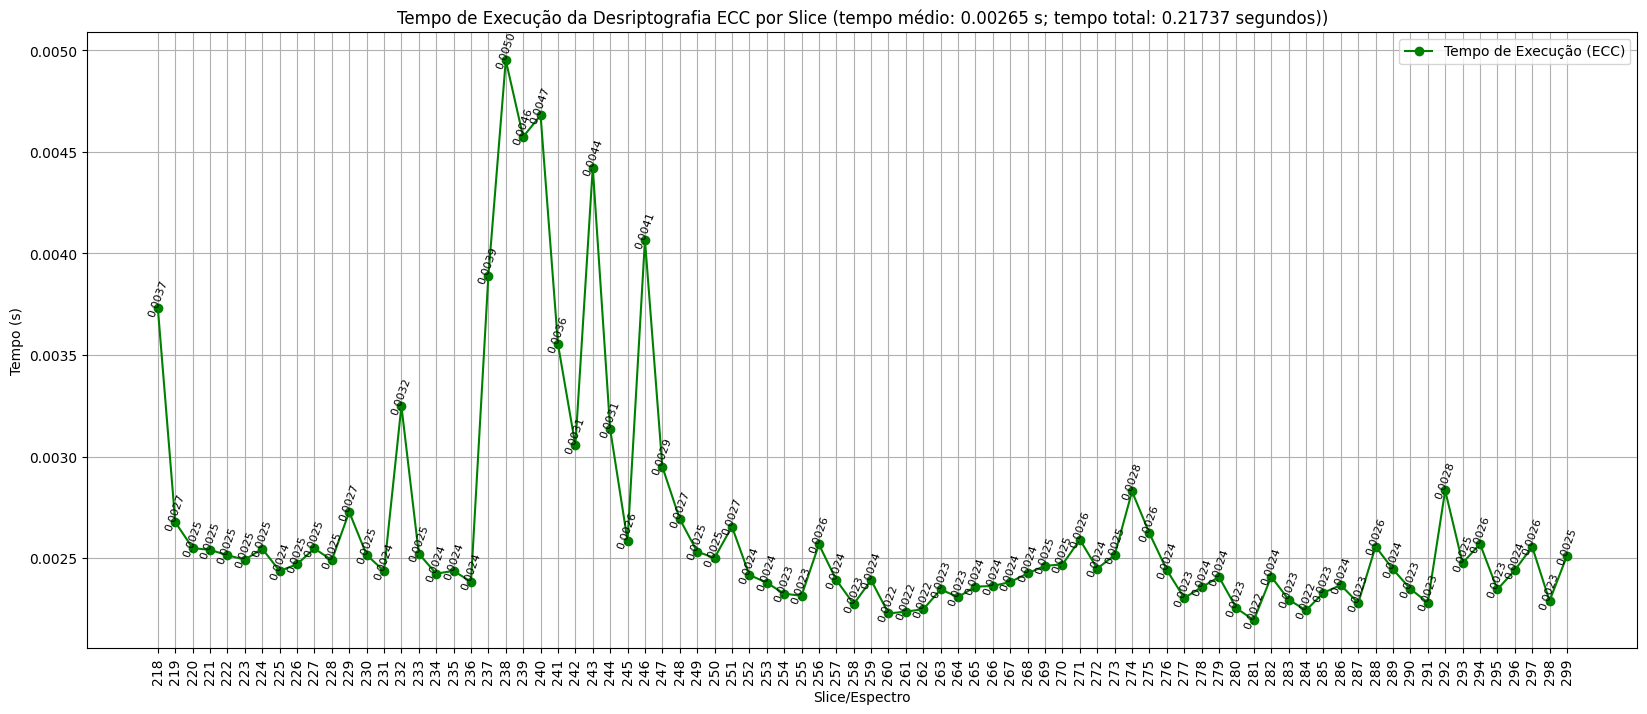

In [15]:
plt.figure(figsize=(20, 8))
plt.plot(execucoes, tempos_execucao, marker='o', linestyle='-', color='green', label='Tempo de Execução (ECC)')

for x, y in zip(execucoes, tempos_execucao):
    plt.text(x, y + 0.00005, f'{y:.4f}', ha='center', va='center', fontsize=8, rotation=70)

plt.xticks(execucoes, rotation=90)
plt.xlabel('Slice/Espectro')
plt.ylabel('Tempo (s)')
plt.title(f'Tempo de Execução da Desriptografia ECC por Slice (tempo médio: {np.mean(tempos_execucao):.5f} s; tempo total: {np.sum(tempos_execucao):.5f} segundos))')
plt.legend()
plt.grid(True)
plt.savefig('output_images/graph_tempo_execucao_ecc_descriptografia_espectro.png')
plt.show()